# Выбор локации для скважины

### Описание проекта

Нужно решить, где бурить новую скважину. Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

### Цель проекта

Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль и  проанализировать возможную прибыль и риски техникой *Bootstrap.*

При выборе локации, будем придерживаться следующих шагов:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Загрузка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from IPython.display import display
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

#!pip install phik -q
import phik
from phik import phik_matrix

TEST_SIZE = 0.25
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample


# Константы с учетом единиц измерения (тыс. баррелей)
INCOME_PER_UNIT = 450  # тыс.руб за тыс.баррелей (450 руб/баррель * 1000)
WELL_COST = 50_000  # тыс.руб на скважину (50 млн руб)
BUDGET = 10_000_000  # тыс.руб (10 млрд руб)
SELECTED_POINTS = int(BUDGET / WELL_COST)  # 200 скважин


In [2]:
try:
    geo_data0 = pd.read_csv("/datasets/geo_data_0.csv", index_col='id')
    geo_data1 = pd.read_csv("/datasets/geo_data_1.csv", index_col='id')
    geo_data2 = pd.read_csv("/datasets/geo_data_2.csv", index_col='id')
except:
    geo_data0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', index_col='id')
    geo_data1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', index_col='id')
    geo_data2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', index_col='id')

In [3]:
# функция для вывода всей нужной информации о датафрейме
def data_info(dataframe):
    print(dataframe.info())
    display(dataframe.head())
    display(dataframe.tail())
    display(dataframe.describe())
    print('Пропусков в датафрейме: ', dataframe.isnull().sum())
    print()
    print('Количество явных дубликатов в датафрейме:', dataframe.duplicated().sum())

In [4]:
data_info(geo_data0)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
id,,,,
DLsed,0.971957,0.370953,6.075346,110.744026
QKivN,1.392429,-0.382606,1.273912,122.346843
3rnvd,1.029585,0.018787,-1.348308,64.375443
7kl59,0.998163,-0.528582,1.583869,74.040764
1CWhH,1.764754,-0.266417,5.722849,149.633246


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Пропусков в датафрейме:  f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов в датафрейме: 0


In [5]:
data_info(geo_data1)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
id,,,,
QywKC,9.535637,-6.878139,1.998296,53.906522
ptvty,-10.160631,-12.558096,5.005581,137.945408
09gWa,-7.378891,-3.084104,4.998651,137.945408
rqwUm,0.665714,-6.152593,1.000146,30.132364
relB0,-3.426139,-7.794274,-0.003299,3.179103


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Пропусков в датафрейме:  f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов в датафрейме: 0


In [6]:
data_info(geo_data2)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
id,,,,
4GxBu,-1.777037,1.125220,6.263374,172.327046
YKFjq,-1.261523,-0.894828,2.524545,138.748846
tKPY3,-1.199934,-2.957637,5.219411,157.080080
nmxp2,-2.419896,2.417221,-5.548444,51.795253
V9kWn,-2.551421,-2.025625,6.090891,102.775767


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Пропусков в датафрейме:  f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов в датафрейме: 0


#### Промежуточный вывод по полученным данным:

geo_data0:
* пропусков и дубликатов нет, данные выглядят нормально

geo_data1:
* пропусков и дубликатов нет, данные выглядят нормально

geo_data2:
* пропусков и дубликатов нет, данные выглядят нормально

### Исследовательский анализ данных

Проведем анализ количественных признаков на предмет аномалий.

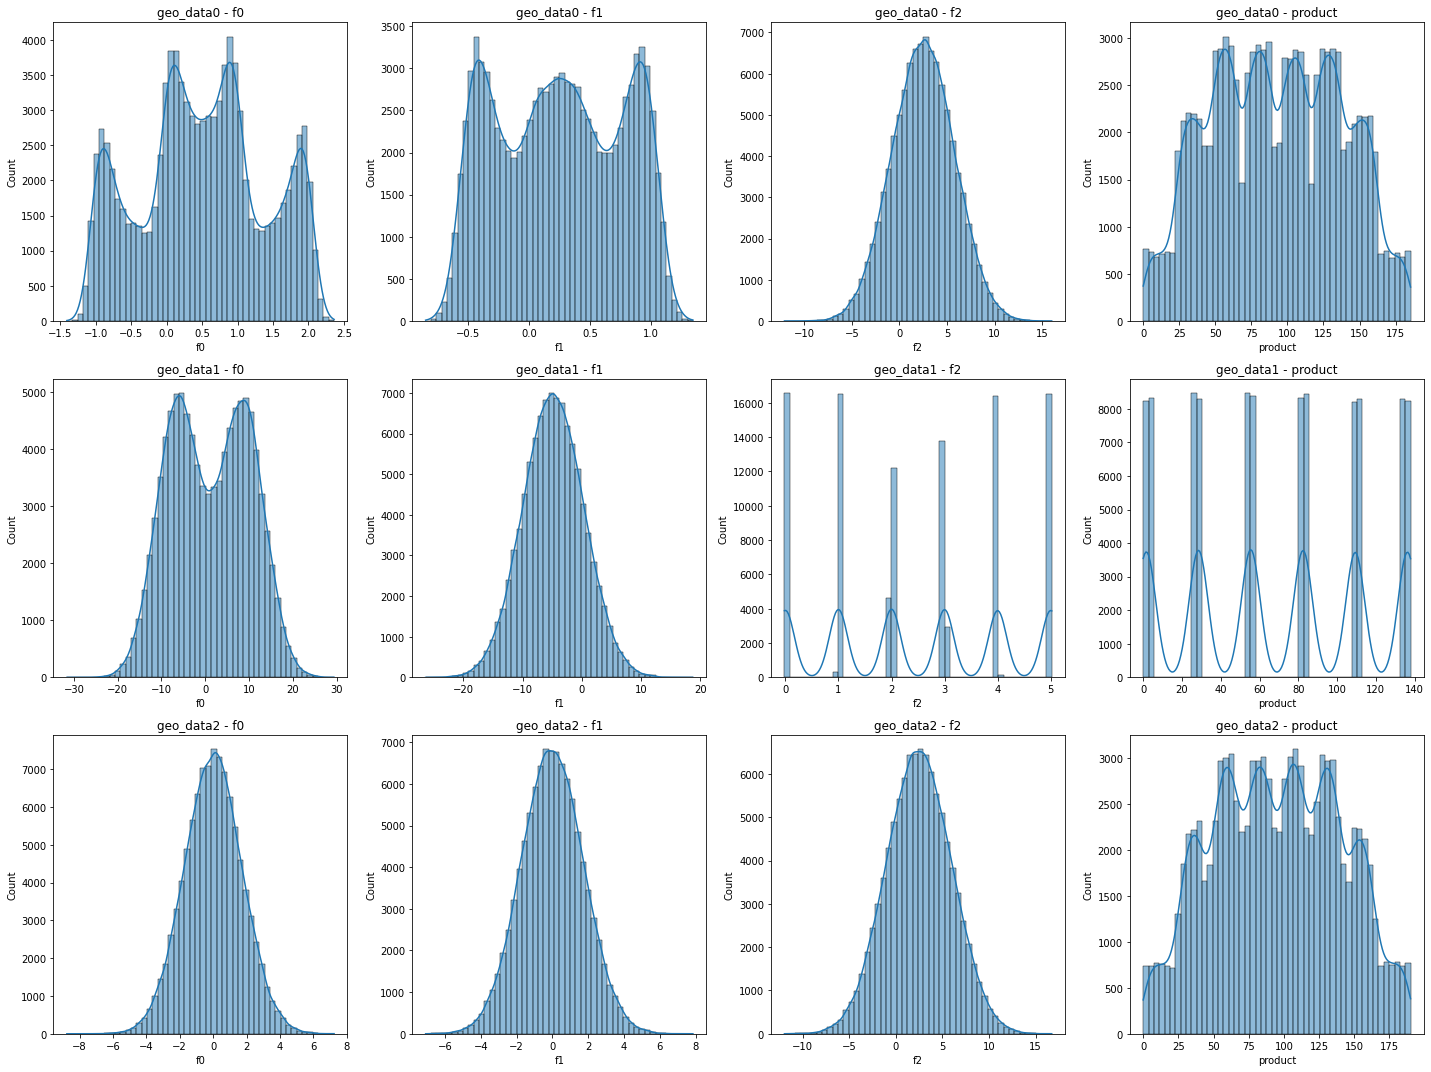

In [7]:
num_col_train=['f0', 'f1', 'f2', 'product']

datasets = [geo_data0, geo_data1, geo_data2]
dataset_names = ['geo_data0', 'geo_data1', 'geo_data2']
colors = ['blue', 'green', 'red']  # Можно задать разные цвета для каждого набора

plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col_train, 1):
    for j, (data, name) in enumerate(zip(datasets, dataset_names), 1):
        plt.subplot(len(datasets), len(num_col_train), (j-1)*len(num_col_train)+i)
        sns.histplot(data[col], kde=True, bins=50)
        plt.title(f'{name} - {col}')
plt.tight_layout()
plt.show()

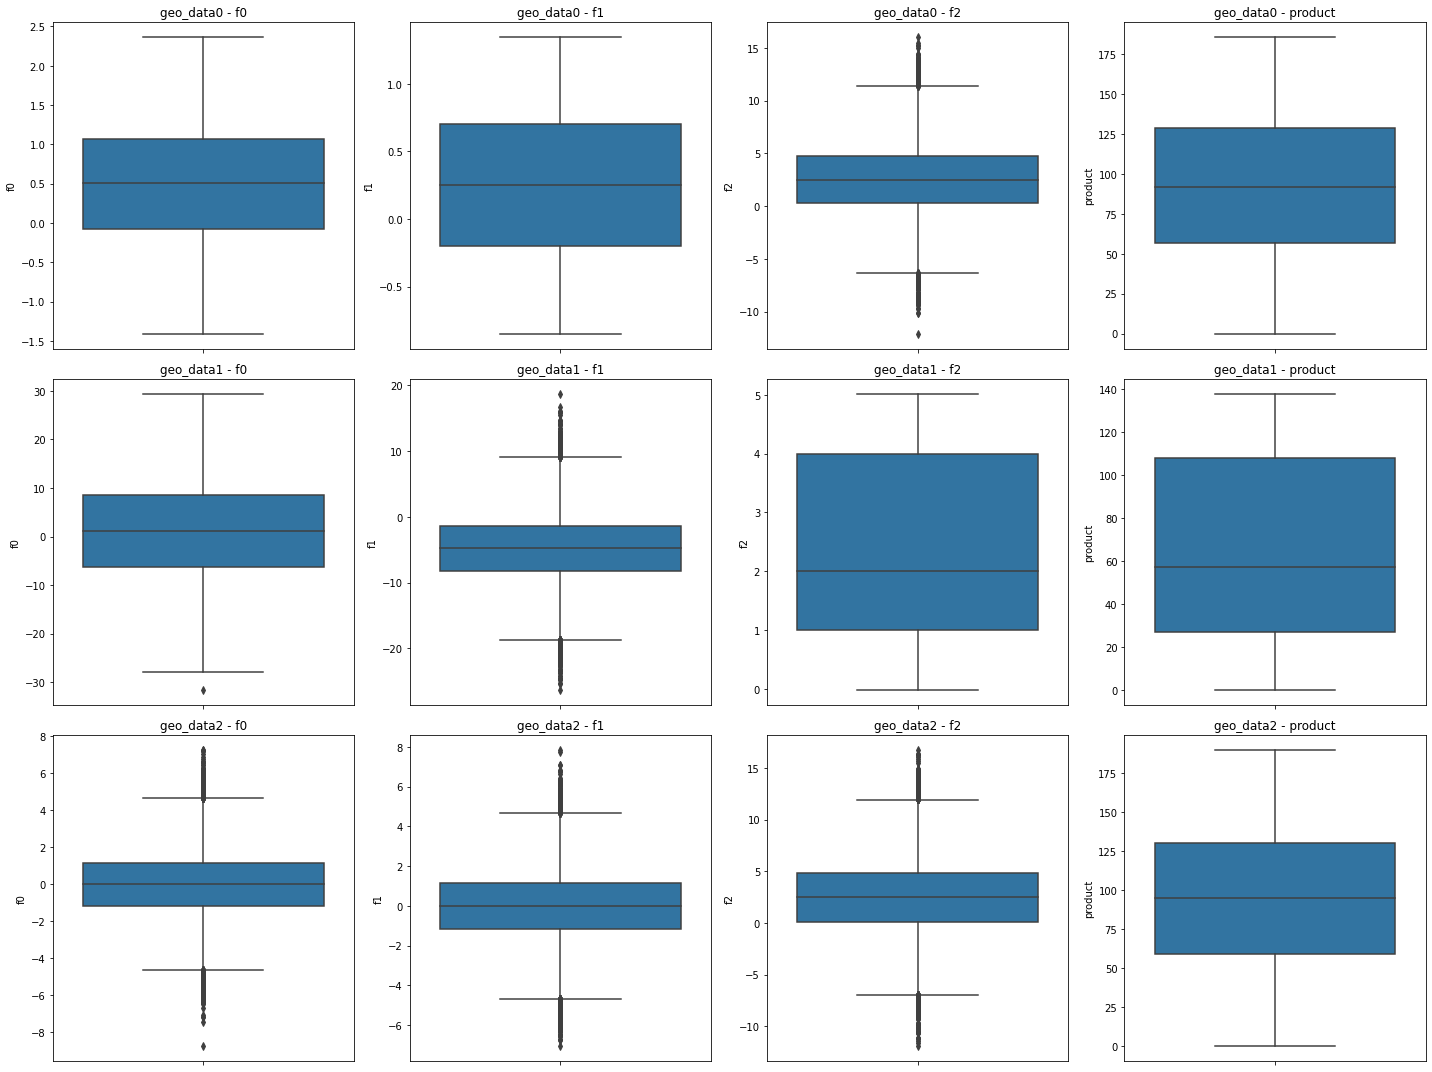

In [8]:
# также построим боксплот
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col_train, 1):
    for j, (data, name) in enumerate(zip(datasets, dataset_names), 1):
        plt.subplot(len(datasets), len(num_col_train), (j-1)*len(num_col_train) + i)
        sns.boxplot(y=data[col])
        plt.title(f'{name} - {col}')
plt.tight_layout()
plt.show()

### Промежуточный вывод по признакам

Видимых аномалий нет. Данные выглядят нормально.

Также посмотрим, есть ли корелляция между признаками.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


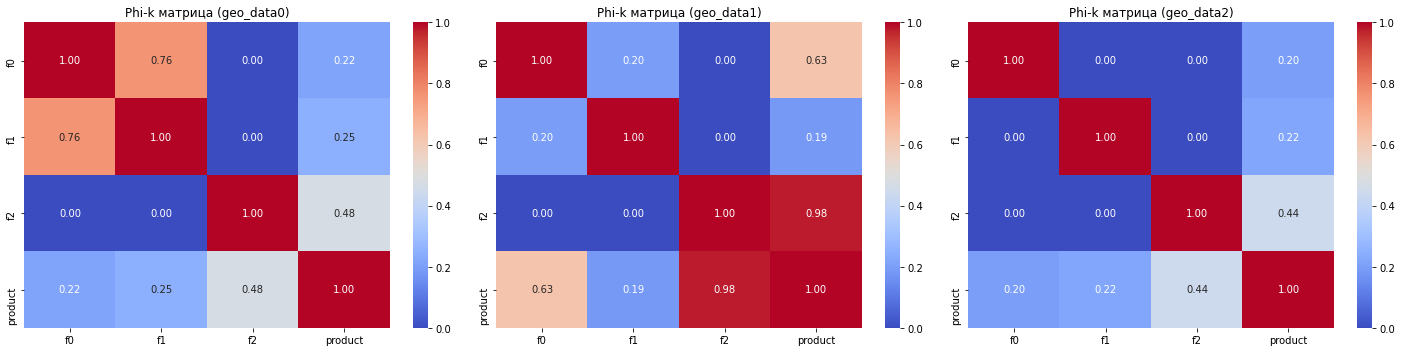

In [9]:
plt.figure(figsize=(20, 5))
for i, (data, name) in enumerate(zip(datasets, dataset_names), 1):
    plt.subplot(1, 3, i)
    phik_corr = data.phik_matrix()
    sns.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
    plt.title(f'Phi-k матрица ({name})')
plt.tight_layout()
plt.show()

В файле geo_data1 входной признак f2 и целевой product слишком сильно кореллируют между собой. Пока оставим его и посмотрим, отразится ли это на результате.

In [10]:
# чтобы не переписывать переменные во всей остальной работе, сделаю так
# плюс, если данные окажутся хуже, то можно будет быстро все вернуть назад
geo_data1_droped = geo_data1
# geo_data1_droped = geo_data1.drop(['f2'], axis = 1)

### Промежуточный вывод по загрузке данных

Пропусков в данных нет, типы столбцов выставлены корректно, дубликатов нет, аномальных значений не обнаружено. Также исследованы кореллирующие признаки.

## Обучение и проверка модели

In [11]:
# создадим списки с исходными данными
names_list = ['geo_data0', 'geo_data1_droped', 'geo_data2']
frames_list = [geo_data0, geo_data1_droped, geo_data2]
results = {}

for name, frame in zip(names_list, frames_list):
    # Разделение на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        frame.drop("product", axis=1),
        frame["product"],
        test_size=0.25,
        random_state=42
    )
    
    # Обучение модели
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ]).fit(X_train, y_train)
    
    # Предсказание на валидационной выборке
    y_pred = model.predict(X_valid)
    
    # Расчёт RMSE
    rmse = mean_squared_error(y_valid, y_pred) ** 0.5
    
    # Сохранение результатов
    results[name] = {
        "model": model,
        "rmse": rmse,
        "mean_predicted": y_pred.mean(),
        "true_values": y_valid,
        "predicted_values": y_pred
    }
    
    # Вывод информации
    print(f"Регион: {name}")
    print(f"Средний запас предсказанного сырья: {y_pred.mean():.2f}")
    print(f"Средний реальный запас: {y_valid.mean():.2f} единиц")
    print(f"RMSE: {rmse:.2f}\n")

Регион: geo_data0
Средний запас предсказанного сырья: 92.40
Средний реальный запас: 92.33 единиц
RMSE: 37.76

Регион: geo_data1_droped
Средний запас предсказанного сырья: 68.71
Средний реальный запас: 68.73 единиц
RMSE: 0.89

Регион: geo_data2
Средний запас предсказанного сырья: 94.77
Средний реальный запас: 95.15 единиц
RMSE: 40.15



### Промежуточный вывод по обучению и проверки модели

Нулевой регион:
* ошибка меньше чем у других(~40%), а средний запас практически такой же как у лидера - второго региона

Первый регион:
* наименьшие запасы нефти среди других регионов, но ошибка минимальна

Второй регион
* средний запас по региону высокий, но также высока ошибка(~42%)

## Подготовка к расчёту прибыли

In [12]:
min_volume_per_well = WELL_COST /INCOME_PER_UNIT
print(f"Минимальный объём на скважину для безубыточности: {min_volume_per_well:.1f} тыс. баррелей")

for name in names_list:
    mean_product = frames_list[names_list.index(name)]["product"].mean()
    print(f"{name}: Средний запас = {mean_product:.1f} тыс. баррелей | {'Достаточно' if mean_product >= min_volume_per_well else 'Недостаточно'}")

Минимальный объём на скважину для безубыточности: 111.1 тыс. баррелей
geo_data0: Средний запас = 92.5 тыс. баррелей | Недостаточно
geo_data1_droped: Средний запас = 68.8 тыс. баррелей | Недостаточно
geo_data2: Средний запас = 95.0 тыс. баррелей | Недостаточно


Ни один регион по средним запасам не подходит, посмотрим распределение значений.

В каждом регионе есть скважины со значениями больше значения безубыточности. Попробуем найти их долю.


Регион: geo_data0
Точка безубыточности: 111.11 единиц
Скважин с запасом > точки безубыточности: 5258 из 25000 (21.0%)


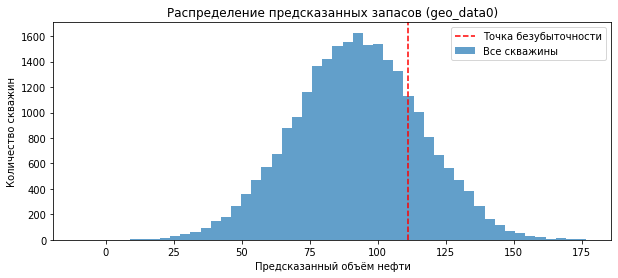


Регион: geo_data1_droped
Точка безубыточности: 111.11 единиц
Скважин с запасом > точки безубыточности: 4520 из 25000 (18.1%)


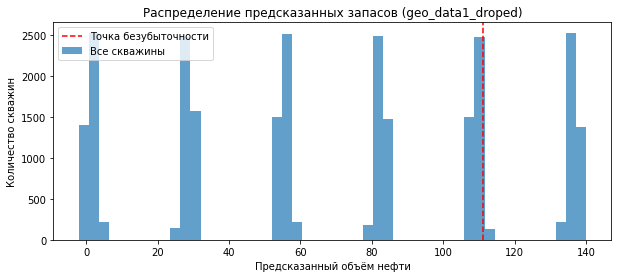


Регион: geo_data2
Точка безубыточности: 111.11 единиц
Скважин с запасом > точки безубыточности: 5239 из 25000 (21.0%)


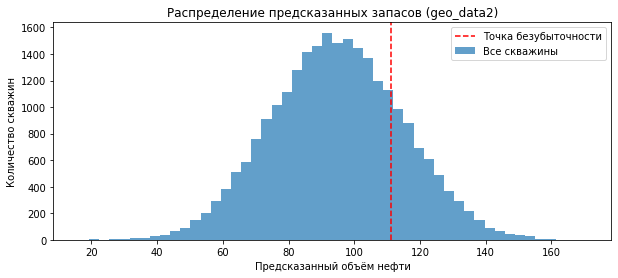

In [13]:
for name in results:
    predicted = results[name]["predicted_values"]
    true_values = results[name]["true_values"]
    
    # Скважины с предсказанным запасом > точки безубыточности
    profitable_wells_mask = predicted > min_volume_per_well
    n_profitable = profitable_wells_mask.sum()
    proportion = n_profitable / len(predicted)
    
    print(f"\nРегион: {name}")
    print(f"Точка безубыточности: {min_volume_per_well:.2f} единиц")
    print(f"Скважин с запасом > точки безубыточности: {n_profitable} из {len(predicted)} ({proportion:.1%})")
    
    # Визуализация распределения предсказанных запасов
    plt.figure(figsize=(10, 4))
    plt.hist(predicted, bins=50, alpha=0.7, label="Все скважины")
    plt.axvline(min_volume_per_well, color='red', linestyle='--', label="Точка безубыточности")
    plt.title(f"Распределение предсказанных запасов ({name})")
    plt.xlabel("Предсказанный объём нефти")
    plt.ylabel("Количество скважин")
    plt.legend()
    plt.show()

### Промежуточный вывод по подготовке к расчету прибыли

Мы выяснили минимальное количество нефти для безубыточной разработки: 111 тысяч баррелей.
Также было выяснено, что, в среднем, ни один регион не подходит. Во время анализа полученных данных было выяснено, что 21% скважин в нулевом и втором регионах проходят данный порог. В первом регионе скважин с безубыточным запасом 18%

## Расчёт прибыли и рисков 

In [14]:
#сначала напишем функцию для рассчета прибыли
def calculate_profit(predictions, true_values, n_selected=SELECTED_POINTS, 
                    well_cost=WELL_COST, income_per_unit=INCOME_PER_UNIT):
    #Расчет прибыли с учетом единиц измерения в тыс. баррелей
    if isinstance(predictions, pd.Series):
        top_indices = predictions.sort_values(ascending=False).head(n_selected).index
        selected_true = true_values.loc[top_indices]
    else:
        top_indices = np.argsort(predictions)[-n_selected:]
        selected_true = true_values[top_indices]
    
    total_revenue = np.sum(selected_true) * income_per_unit  # тыс.руб
    total_cost = well_cost * n_selected  # тыс.руб
    return total_revenue - total_cost, selected_true

In [15]:
# функция для Bootstrap
def bootstrap_profit_analysis(predictions, true_values, n_bootstrap=1000, sample_size=500):
    """Bootstrap-анализ с правильными единицами измерения"""
    profit_samples = []
    
    for _ in range(n_bootstrap):
        # Сэмплируем 500 скважин (в тыс. баррелей)
        idx = np.random.choice(range(len(predictions)), size=sample_size, replace=True)
        pred_sample = predictions[idx]
        true_sample = true_values.iloc[idx] if hasattr(true_values, 'iloc') else true_values[idx]
        
        # Выбираем топ-200 из 500
        top_indices = np.argsort(pred_sample)[-SELECTED_POINTS:]
        selected_true = true_sample[top_indices]
        
        # Расчет в тыс.руб
        total_revenue = np.sum(selected_true) * INCOME_PER_UNIT
        total_cost = WELL_COST * SELECTED_POINTS
        profit = total_revenue - total_cost
        
        profit_samples.append(profit)
    
    profit_samples = np.array(profit_samples)
    risk = max(np.mean(profit_samples < 0), 0.001)  # Минимум 0.1%
    
    return {
        "mean_profit": np.mean(profit_samples) / 1e3,  # переводим в млн руб
        "confidence_interval": np.percentile(profit_samples, [2.5, 97.5]) / 1e3,
        "risk_of_loss": risk
    }

Применим функции для каждого региона.

In [16]:
# Основной анализ для всех регионов
for name in names_list:
    predictions = results[name]["predicted_values"]
    true_values = results[name]["true_values"]
    
    # Точечная оценка прибыли
    profit, selected_true = calculate_profit(predictions, true_values)
    
    # Bootstrap анализ
    bootstrap_result = bootstrap_profit_analysis(predictions, true_values)
    
    print(f"\nРегион: {name}")
    print(f"Средний запас топ-200: {np.mean(selected_true):.2f} тыс.баррелей")
    print(f"Прибыль: {profit/1e3:.2f} млн руб") 
    print(f"95% ДИ: [{bootstrap_result['confidence_interval'][0]:.2f}, {bootstrap_result['confidence_interval'][1]:.2f}] млн руб")
    print(f"Риск убытков: {bootstrap_result['risk_of_loss']:.1%}")


Регион: geo_data0
Средний запас топ-200: 148.43 тыс.баррелей
Прибыль: 3359.14 млн руб
95% ДИ: [-81.19, 922.74] млн руб
Риск убытков: 6.2%

Регион: geo_data1_droped
Средний запас топ-200: 137.95 тыс.баррелей
Прибыль: 2415.09 млн руб
95% ДИ: [46.75, 826.71] млн руб
Риск убытков: 1.3%

Регион: geo_data2
Средний запас топ-200: 139.98 тыс.баррелей
Прибыль: 2598.57 млн руб
95% ДИ: [-143.75, 890.02] млн руб
Риск убытков: 8.2%


# Общий вывод:

 В ходе работы была проведена комплексная аналитика данных по трём нефтеносным регионам для определения оптимального местоположения бурения новых скважин.

### Ключевые этапы и выводы:

#### Первичный осмотр и обработка данных:
 При первичном осмотре, с данными оказалось все нормально, без пропусков и аномальных значений\выбросов. После был проведен корелляционный анализ, чтобы можно было адекватно обучить модель линейной регрессии. Мультиколлинеарность в сете geo_data1 была удалена.
 
#### Предварительный анализ данных

* Для каждого региона построена модель линейной регрессии, предсказывающая объём запасов нефти.

Определена точка безубыточности (111.11 единиц нефти на скважину), и выяснено, что:

* В первом регионе(geo_data1_droped) есть неубыточные скважины, с долей 18%, хотя их средний запас невелик(68.73ед).

- В нулевом(geo_data0) и во втором(geo_data2) также есть скважины с достаточным запасом (их доля 21%).

#### Расчёт прибыли и оценка рисков

Для каждого региона была применена Bootstrap-симуляция (1000 выборок):

* geo_data0:

    - Средняя прибыль — 3.36 млрд руб.

    - Риск убытков — 6,2%.
    
* geo_data1:
    - Средняя прибыль — 2.42 млрд руб.
    
    - Риск убытков — 2,1%.
    
* geo_data2:

    - Средняя прибыль — 2.6 млрд руб.

    - Риск убытков — 8,1%.

#### Рекомендации:
* Оптимальный выбор — регион geo_data0, так как он обеспечивает:

    - Максимальную прибыль (на 0.76 млрд руб выше, чем geo_data2).

    - Умеренный риск убытков, если мы готовы увеличить риски.
    
* Если требуется, чтобы убытков было *как можно меньше* и возможная потеря 1 миллиарда подходит, то следует выбрать регион geo_data1

#### Дополнительные возможности:

* Для geo_data1 и geo_data2 провести дополнительный геологический анализ — возможно, есть локальные "зоны" с аномально высокими запасами.
- Эти регионы также подходят для разработки, но с них получим гораздо меньшую прибыль. Возможно, для диверсификации можно выбрать один из регионов.

Резюмирируем: Компании «ГлавРосГосНефть» следует начать разработку в регионе geo_data0 для максимизации прибыли при контролируемых рисках. Но если требуется минимальный риск убытков и допустима меньшая прибыль, то регион geo_data1 - лучший вариант.